In [ ]:
pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 4.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt

## Here i am uploading an image

In [2]:
image = sitk.ReadImage("picai_public_images_fold1/10010/10010_1000010_t2w.mha") 

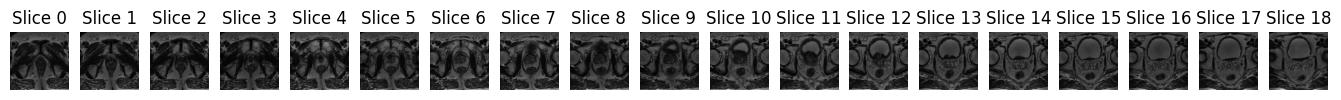

In [3]:
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

In [4]:
pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## so there is 2 things: the nii files that on my understading have the color coded images and the csv file that have the labels for each image

### here is my attempt to open the nii files but it is not showing right

In [31]:
import nibabel as nib


In [32]:
path = '10035_1000035.nii'

In [33]:
img = nib.load(path).get_fdata()
img.shape

(384, 384, 27)

In [34]:
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


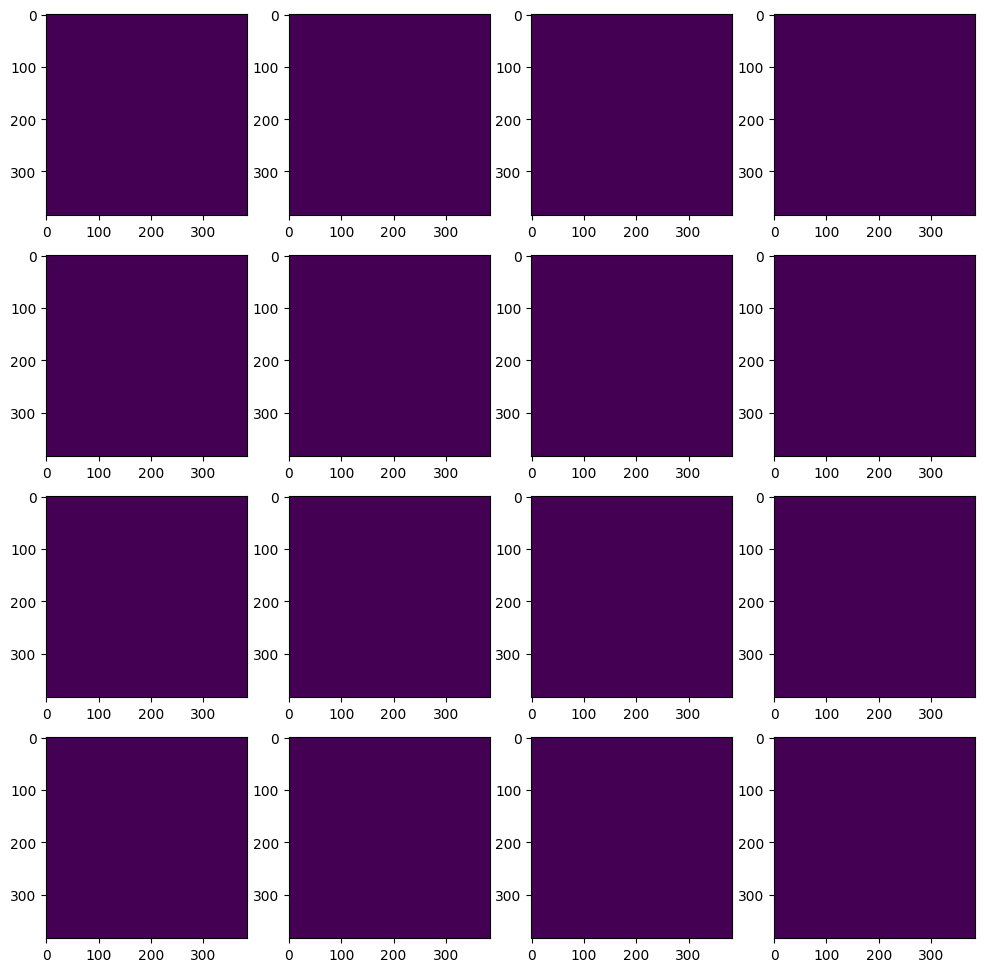

In [35]:
plt.style.use('default')
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,1 + i])
plt.show()

### i will try to open the csv file and see if i can get the labels

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [36]:
#opening the csv file
import pandas as pd
df = pd.read_csv("marksheet.csv")

In [42]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO


In [41]:
#want to see how many case_csPCA are positive
df['case_csPCa'].value_counts()

NO     1075
YES     425
Name: case_csPCa, dtype: int64

# Training a basic ResNet model

In [44]:
from torchvision.models import resnet50, ResNet50_Weights

# # Old weights with accuracy 76.130%
# model1 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
model2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/kimberlyllajarunaperalta/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
 24%|██▎       | 23.2M/97.8M [00:05<00:17, 4.41MB/s]


KeyboardInterrupt: 